In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import variation

## To do:

- take the variance of each year (can do this as constant parameters for each year) and then find the mean of these over the simulations 
- variance between infectious individuals per day - but its not per day - what am I calculating variance of? -- total number of individuals infectious at each given time 

- ODEs can only model decrease in epsilon and not initial conditions 
- ergodic: same behavior averaged over time as averaged over the space of all the system's states (ensemble average vs time average) -- assumes stationary (at steady state) which might not be true 
- write in report about steady state and ergodic behaviour
- might take a truncated distribution of exposed individuals, same mean as predicted but with a tail
- compare decreasing epsilon and beta -- talk about interventions, some stats and whether control teams should focus on the bats or the humans
- Write up parametre fitting properly: read hollingsworth case study + ben

# Variance of Fluctuations - FIND ERROR AND FIX
From expansion of the master equations we get the FPE. Explains the macroscopic behaviour with the fluctuations around the mean. From here, the change in variance can be described as $\frac{d<\xi^2>_t}{dt}$ (since $\frac{d<\xi>_t}{dt} = 0 $) 

$$\frac{d <\xi^2>_t}{dt} = 2\beta \phi <\eta \xi> + 2(\beta \psi - \mu) <\xi^2> + \phi (\beta \psi + \mu + \gamma ) \\
\frac{d <\eta ^2>_t}{dt} = -2(\beta \phi + \mu)<\eta ^2> - 2(\beta \psi) <\eta \xi> + \phi \beta \psi +\mu(1- \psi) \\
\frac{d <\eta \xi >_t}{dt} = -(\beta \phi + \mu)<\eta ^2> + \beta(\phi - \psi) <\eta \xi> + (\beta \psi - \mu) <\xi ^2> - \phi(\mu +\beta \psi) $$ 
Where $\phi = \frac{<I>}{N}$ and $\psi = \frac{<S>}{N}$ and $$\frac{d\phi}{dt} = \beta \phi \psi - \mu \phi - \gamma \phi  \\
\frac{d \psi }{dt} = -\beta \phi \psi +\mu \phi + \mu (1- \phi - \psi ) $$

$$\beta(t) = (1-pt)\beta_0$$

Compare this to numerical solutions - simulate the system multiple times and plot the variance between these simulations at each time point. 

In [2]:
def gillespieSIR(initial, beta0,p, gamma,mu, max_time):
    T = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    T.append(0)
    t = 0
    ind = 0
    while t <max_time:
        betat = (1-p*t)*beta0
#         print(betat)
        state = np.zeros(shape= (3,4))
        R1 = betat*(pop[ind][0])*(pop[ind][1])/N
        state[:,0] = [-1, 1, 0]
        R2 = gamma*(pop[ind][1])
        state[:,1] = [0, -1,1]
        R3 = mu*(pop[ind][1])
        state[:,2] = [1, -1, 0]
        R4 = mu*(pop[ind][2])
        state[:,3] = [1,0,-1]
        rate = [R1, R2, R3, R4]
        Rtotal = sum(rate)
        if Rtotal >0:
            delta_t= -np.log(np.random.uniform(0,1))/Rtotal

            P = np.random.uniform(0,1)*Rtotal
            t =t+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            T.append(t)
            pop.append(pop[ind]+state[:,event])
        else: 
            t = max_time
#             year = year +1 
#             events.append(-1)
            T.append(t)
            pop.append(pop[ind])
        ind=ind+1
    return T, np.array(pop)

In [3]:
def gillsteps(G):
    t = G[0]
    s = G[1][:,0]
    i = G[1][:,1]
    r = G[1][:,2]
    stept = []
    steps = []
    stepi = []
    stepr = []
    for ind, x in enumerate(t):
        if ind<len(t)-1:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepr.append((r[ind], r[ind]))
            stept.append((t[ind], t[ind+1]))
        else:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stept.append((t[ind], t[ind]))
            stepr.append((r[ind], r[ind]))

    steps = np.array(steps).flatten()
    stepi = np.array(stepi).flatten()
    stepr = np.array(stepr).flatten()
    stept = np.array(stept).flatten()
    return stept, steps, stepi, stepr

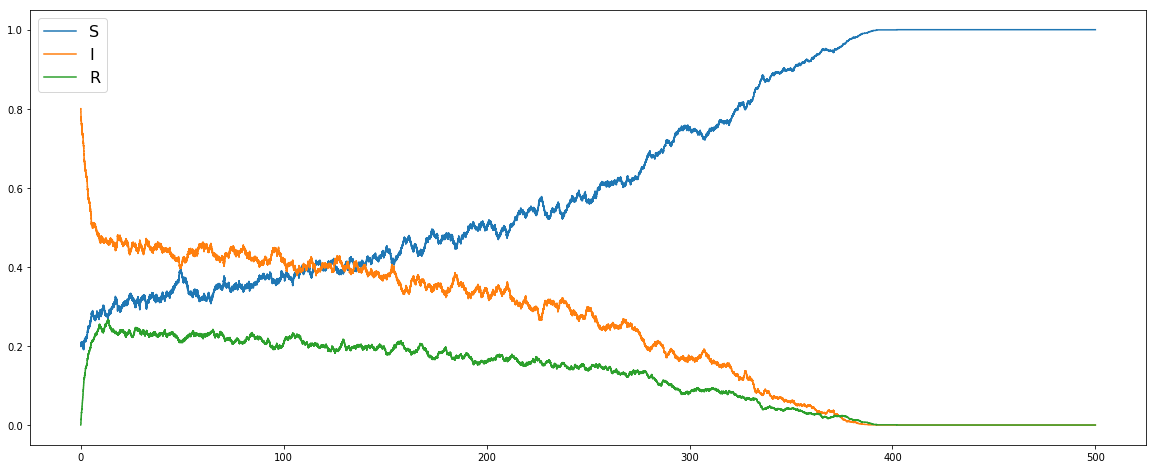

In [4]:
N = 2000
T = 500
G = gillespieSIR([N-0.8*N,0.8*N, 0], 1,1/500, 0.1,0.2, T)



plt.figure(figsize = (20,8))
plt.plot(gillsteps(G)[0], gillsteps(G)[1]/N, label = 'S')
plt.plot(gillsteps(G)[0], gillsteps(G)[2]/N, label = 'I')
plt.plot(gillsteps(G)[0], gillsteps(G)[3]/N, label = 'R')

plt.legend(fontsize = 16)

In [5]:
inter_t = np.arange(0, round(max(gillsteps(G)[0])) +1 , 1) #interpolate to daily steps
inter_inf = np.interp(inter_t, gillsteps(G)[0],gillsteps(G)[2])

In [6]:
# plt.plot(inter_t, inter_inf)
# plt.plot()
β_0 =1
# β = 1
p=1/500
γ = 0.1
μ = 0.2
A = np.matrix([[-β_0 - μ, -β_0],[β_0, β_0 - μ - γ]])
print(A)
A.transpose()
μ

[[-1.2 -1. ]
 [ 1.   0.7]]


0.2

In [7]:
T = 500
SIM = 50
simulations = np.zeros(shape=(SIM, T))
for k in range(SIM):
    G = gillespieSIR([0.2*N,0.8*N, 0], β_0,p,γ, μ, T)
    inter_t = np.arange(0, round(max(gillsteps(G)[0])) +1 , 1) #interpolate to daily steps
    inter_inf = np.interp(inter_t, gillsteps(G)[0],gillsteps(G)[2])
    if round(max(gillsteps(G)[0]))<T:
        simulations[k,: ] =  np.concatenate([inter_inf,np.zeros(T - len(inter_inf))])
    else:
        simulations[k,:] = inter_inf[:T]

In [87]:
def integrand(x, alpha, D22, dd, tt):
    return (alpha + D22*(x**2))/((x**2-dd)**2 + (tt**2)*(x**2))
from scipy.integrate import quad

# var = (( (2 a + 2 b s + b T (-T + np.sqrt[-4 s + T^2]))/np.sqrt[-2 s + T (T - np.sqrt[-4 s + T^2])]) + ((-2 a - 2 b s + 
#     b T (T + np.sqrt[-4 s + T^2]))/np.sqrt[-2 s + T (T + np.sqrt[-4 s + T^2])]))/(np.sqrt[2] T np.sqrt[-4 s + T^2])

In [107]:
N

2000

In [125]:
quasi = []
quasi2 = []
quasi_cov = []
Q = []
for k in range(500):
    b = β_0*(1-p*k)
    #####fixed points #####
    star0 = (μ+γ)/b
    star1 = μ*(1-star0)/(b*star0)
    
    ##### matrices A and B ######
    A= np.matrix([[-b*star1 - μ, -b*star0], [b*star1, b*star0 - μ - γ]])
    B = np.matrix([[b*star0*star1 + μ*(1-star0), -star1*(b*star0 + μ)],[-star1*(μ+b*star0), star1*(b*star0 + μ+γ)]])
    
    
    alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    det = np.linalg.det(A)
    tra = np.trace(A)
    
    ######### Integration #########
    
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alph,B[1,1], det, tra))[0]
    
    quasi.append(S/N)
    quasi_cov.append(np.sqrt(S/N)/star1)

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


In [111]:
np.pi

3.141592653589793

In [112]:
def covariance(X,t):
    beta = β_0*(1-p*t)
    X0_ψ = -beta*X[0]*X[1] +μ*(1-X[0])
    X1_ϕ = beta*X[0]*X[1] - μ*X[1] - γ*X[1]
    A= np.matrix([[-beta*X[1] - μ, -beta*X[0]], [beta*X[1], beta*X[0] - μ - γ]])
    B = np.matrix([[beta*X[0]*X[1] + μ*(1-X[0]), -X[1]*(beta*X[0] + μ)],[-X[1]*(μ+beta*X[0]), X[1]*(beta*X[0] + μ+γ)]])
    Θ = np.matrix([[X[2], X[3]],[X[3], X[4]]])
#     print(A)
    K = A*Θ +Θ*A.transpose()+B
    return [X0_ψ, X1_ϕ, K[0,0], K[0,1], K[1,1]]

In [113]:

ts = np.linspace(0, T, 1000)
P = odeint(covariance, [0.2,0.8, 0, 0 , 0], ts)
# plt.plot(ts[:10], P[:,4][:10])

In [114]:
time = np.arange(0, 500, 1)
varI= np.interp(time, ts, P[:,4] )
meanI = np.interp(time, ts, P[:,1])

In [115]:
t_star = (1/p)*(1- ((γ+μ)/β_0))
t_star
# simulations[0:k,:]
np.mean(P[:,1])

0.23595932736571837

In [116]:
quasi[round(t_star)]
quasi

[0.0008516666666666666,
 0.0008520072877886703,
 0.0008523491556587797,
 0.0008526922770695266,
 0.000853036658862296,
 0.0008533823079277625,
 0.0008537292312063246,
 0.0008540774356885507,
 0.0008544269284156257,
 0.0008547777164798002,
 0.0008551298070248506,
 0.0008554832072465405,
 0.0008558379243930843,
 0.0008561939657656214,
 0.0008565513387186911,
 0.0008569100506607148,
 0.0008572701090544816,
 0.0008576315214176408,
 0.0008579942953231981,
 0.0008583584384000179,
 0.0008587239583333333,
 0.0008590908628652536,
 0.0008594591597952885,
 0.0008598288569808683,
 0.0008601999623378763,
 0.000860572483841182,
 0.0008609464295251827,
 0.0008613218074843525,
 0.0008616986258737908,
 0.0008620768929097866,
 0.0008624566168703786,
 0.0008628378060959292,
 0.0008632204689897001,
 0.0008636046140184356,
 0.0008639902497129561,
 0.0008643773846687476,
 0.0008647660275465715,
 0.0008651561870730686,
 0.0008655478720413787,
 0.0008659410913117604,
 0.0008663358538122244,
 0.000866732168539

In [117]:
Q

[0.0008516666666666666,
 0.0008520072877886702,
 0.0008523491556587798,
 0.0008526922770695266,
 0.0008530366588622962,
 0.0008533823079277627,
 0.0008537292312063246,
 0.0008540774356885507,
 0.0008544269284156258,
 0.0008547777164798004,
 0.0008551298070248507,
 0.0008554832072465405,
 0.0008558379243930843,
 0.0008561939657656214,
 0.0008565513387186912,
 0.000856910050660715,
 0.0008572701090544818,
 0.000857631521417641,
 0.0008579942953231981,
 0.0008583584384000181,
 0.0008587239583333334,
 0.0008590908628652536,
 0.0008594591597952885,
 0.0008598288569808685,
 0.0008601999623378763,
 0.0008605724838411821,
 0.0008609464295251828,
 0.0008613218074843526,
 0.0008616986258737909,
 0.0008620768929097867,
 0.0008624566168703788,
 0.0008628378060959297,
 0.0008632204689897003,
 0.0008636046140184358,
 0.0008639902497129564,
 0.0008643773846687481,
 0.0008647660275465715,
 0.0008651561870730688,
 0.0008655478720413787,
 0.000865941091311761,
 0.0008663358538122248,
 0.0008667321685391

/home/emma/.local/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


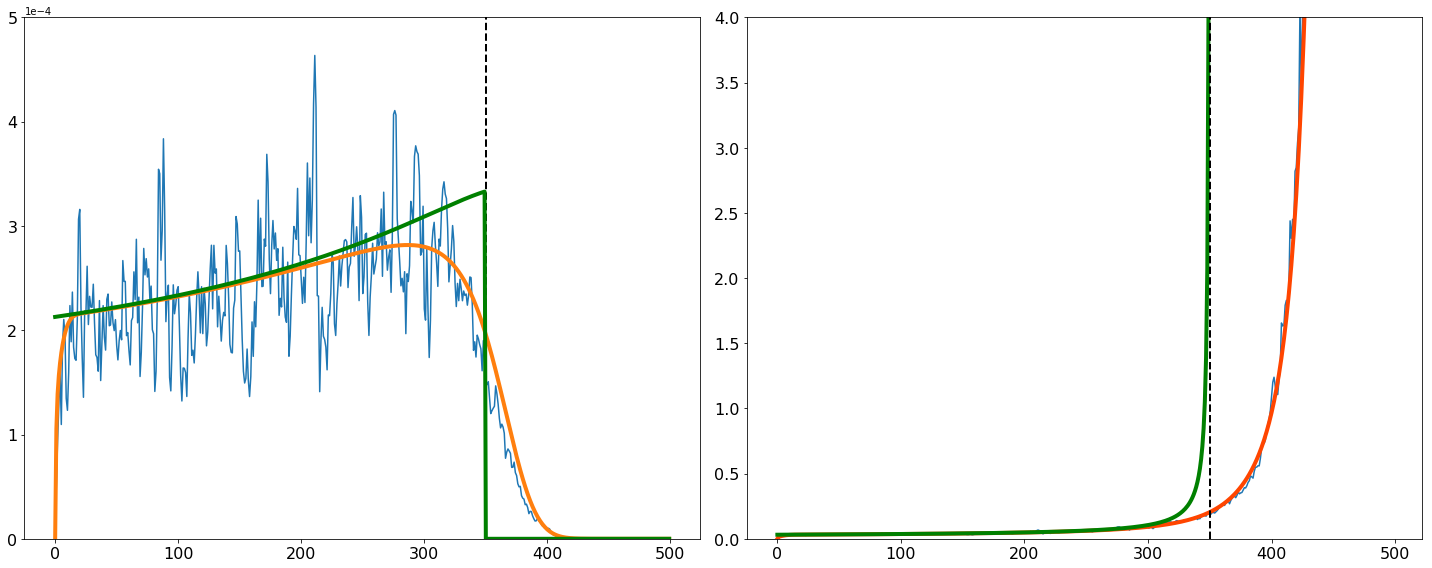

In [152]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(T), np.var(simulations/N, axis = 0), label = 'simulations')
plt.plot(time, varI/N, linewidth = 4, label = 'Variance') 
plt.plot([t_star, t_star], [0, 0.0005], '--',c = 'k',linewidth = 2, label =  '$R_{0} = 1$')
plt.plot(range(T), np.maximum(quasi,0), linewidth = 4,c='green', label = 'Quasi-stationary')
# plt.plot(range(T), np.maximum(quasi2, 0))
# plt.legend(fontsize =20, loc = 'upper left')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([0,0.0005])

plt.tight_layout()
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(1,2,2)
plt.plot(range(T), variation(simulations/N, axis = 0))
# plt.plot(ts, P[:,4]/N, label = 'Variance') 
plt.plot(time, np.sqrt(varI/N)/(meanI), linewidth =4,  c ='orangered', label =  'Coefficient of \n Variance')
plt.plot(range(T), quasi_cov,  linewidth = 4, c='green')
plt.plot([t_star, t_star], [0, 7], '--', linewidth = 2, c = 'k')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# plt.plot(ts, -Q[:,3], label = '2nd')
# plt.legend(fontsize =16)
# plt.xlim([-1,50])
plt.ylim([0,4])
plt.tight_layout()
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

/home/emma/.local/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


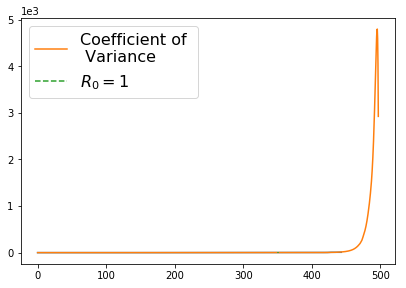

In [81]:
plt.plot(range(T), variation(simulations/N, axis = 0))
# plt.plot(ts, P[:,4]/N, label = 'Variance') 
plt.plot(ts, np.sqrt(P[:,4]/N)/(P[:,1]), label =  'Coefficient of \n Variance')
plt.plot([t_star, t_star], [0, 7], '--',label =  '$R_{0} = 1$')
# plt.plot(ts, -Q[:,3], label = '2nd')
plt.legend(fontsize =16)
# plt.xlim([-1,50])
# plt.ylim([0,1])
plt.tight_layout()
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

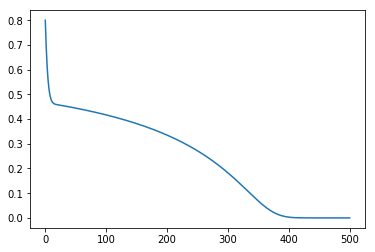

In [90]:
# plt.plot(range(T), np.mean(simulations/N, axis = 0))

plt.plot(ts, P[:,1])

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


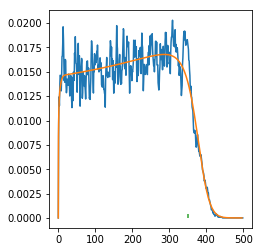

In [82]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(range(T), np.std(simulations/N, axis = 0))
plt.plot(ts, np.sqrt(P[:,4]/N), label = 'Variance') 
plt.plot([t_star, t_star], [0, 0.00045], '--',label =  '$R_{0} = 1$')

In [89]:
print((P[:,1])[400])
print(np.mean(simulations/N, axis = 0)[400])

0.33494554190970677
0.003030000000000001


In [93]:
len(P[:,1])
len(simulations[0,:])

500